# Credit card fraud detection through isolation forest

### Import Data

In [1]:
#!pip install scikit-learn==1.1.1

In [2]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append("/Isolation-Forest-For-Fraud-Detection/src/")
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest,RandomForestClassifier
from src.preprocessing.data import read_all_trx, train_test_split_transactions
from src.preprocessing.features import create_feature_matrix
from src.model.performance import evaluate_model, random_search_cv,time_window_cv
from src.preprocessing.helpers import scenario_sample
from src.plotting_functions.plot_results import * 

from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [4]:
#______________________________ DATA______________________________________
start = '2018-04-01'
end = '2018-09-30'
calendar = pd.date_range(start, end, inclusive="both").strftime('%Y-%m-%d')
root = "https://github.com/Fraud-Detection-Handbook/simulated-data-raw/blob/main/data/"
path_data = [f"{root}{date}.pkl?raw=true" for date in calendar]
transactions_df = read_all_trx(path_data).sort_values('TX_DATETIME').reset_index(drop=True)
scenario_1 = transactions_df.loc[transactions_df["TX_FRAUD_SCENARIO"] == 1]
scenario_2 = transactions_df.loc[transactions_df["TX_FRAUD_SCENARIO"] == 2]
scenario_3 = transactions_df.loc[transactions_df["TX_FRAUD_SCENARIO"] == 3]
#_________________________________________________________________________

Execution time: 170.5833306312561 seconds


In [5]:
scenario_1.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
3527,3527,2018-04-01 10:17:43,3774,3059,225.41,37063,0,1,1
5789,5790,2018-04-01 13:31:48,4944,6050,222.26,48708,0,1,1
6549,6549,2018-04-01 14:42:02,4625,9102,226.40,52922,0,1,1
10354,10355,2018-04-02 05:03:35,2513,1143,222.04,104615,1,1,1
10749,10749,2018-04-02 06:06:00,3770,5671,264.95,108360,1,1,1


In [6]:
transactions_df.shape

(1754155, 9)

### Creating Features

In [7]:
#__________________________ FEATURES _________________________________
X = create_feature_matrix(transactions_df,windows_size_in_days = [1,5,7,15,30],delay_period=7)
target = "TX_FRAUD"

index = "TX_DATETIME"

train_period = "2018-07-01"

customer_features = [i for i in X.columns if "CUSTOMER_ID_" in i]

flag_features = [i for i in X.columns if "TX_FLAG_" in i]

terminal_features = [i for i in X.columns if "TERMINAL_ID_" in i]

time_features = ['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_MONTH', 'TX_DAY', 'TX_HOUR', 'TX_MINUTE', 'TX_DURING_WEEKEND',
                 'TX_DURING_NIGHT']

helper_columns = ['TX_FRAUD', 'TX_FRAUD_SCENARIO', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID']

features = ['TX_AMOUNT'] + flag_features + terminal_features + customer_features + time_features
#___________________________________________________________________

### Cross Validation in Time and Features

In [8]:
model = IsolationForest()
#________________________ FEATURE INDEPENDENT SPLIT _________________________
basic = ['TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']
features = ['TX_AMOUNT'] + flag_features + terminal_features + customer_features + time_features
auc_are_feat_type  = pd.DataFrame()
for feats in [basic,customer_features,time_features,terminal_features,features]:
    # Reports Performance
    auc_are_feat_type = pd.concat([auc_are_feat_type,time_window_cv(transactions_df,model,feats)],0)

indexlist = []
for feat in ["raw_features", "customer_features", "time_features", "terminal_features","total_features"]:
    for time in range(1, 3):
        indexname = feat + f"_time_folder_{time}"
        indexlist.append(indexname)
auc_are_feat_type.index = indexlist

validation_values  = auc_are_feat_type["validation"].explode()[0::3]
validation_values.name = "AUC"
validation_values.index = indexlist
auc_are_feat_type = pd.concat([auc_are_feat_type,validation_values],1)

Creating features...
Start Time Cross Validation...
Train: 2018-04-01 00:00:31 2018-06-01 00:00:31
Test: 2018-07-01 00:00:31 2018-08-01 00:00:31
Train: 2018-05-01 00:00:31 2018-07-01 00:00:31
Test: 2018-08-01 00:00:31 2018-09-01 00:00:31
Creating features...
Start Time Cross Validation...
Train: 2018-04-01 00:00:31 2018-06-01 00:00:31
Test: 2018-07-01 00:00:31 2018-08-01 00:00:31
Train: 2018-05-01 00:00:31 2018-07-01 00:00:31
Test: 2018-08-01 00:00:31 2018-09-01 00:00:31
Creating features...
Start Time Cross Validation...
Train: 2018-04-01 00:00:31 2018-06-01 00:00:31
Test: 2018-07-01 00:00:31 2018-08-01 00:00:31
Train: 2018-05-01 00:00:31 2018-07-01 00:00:31
Test: 2018-08-01 00:00:31 2018-09-01 00:00:31
Creating features...
Start Time Cross Validation...
Train: 2018-04-01 00:00:31 2018-06-01 00:00:31
Test: 2018-07-01 00:00:31 2018-08-01 00:00:31
Train: 2018-05-01 00:00:31 2018-07-01 00:00:31
Test: 2018-08-01 00:00:31 2018-09-01 00:00:31
Creating features...
Start Time Cross Validation

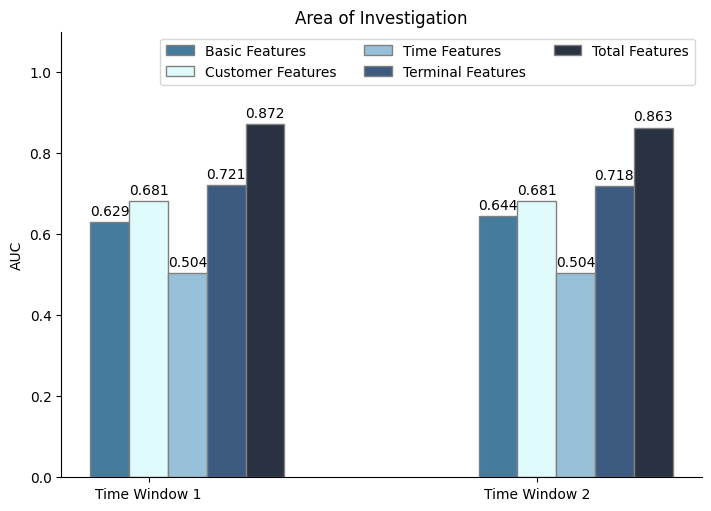

In [9]:
aucs = auc_are_feat_type["AUC"].astype(float).round(3)
auc_means = {
    'Basic Features': (aucs["raw_features_time_folder_1"], aucs["raw_features_time_folder_2"]),
    'Customer Features':  (aucs["customer_features_time_folder_1"], aucs["customer_features_time_folder_2"]),
    'Time Features':  (aucs["time_features_time_folder_1"], aucs["time_features_time_folder_2"]),
    'Terminal Features':  (aucs["terminal_features_time_folder_1"], aucs["terminal_features_time_folder_2"]),
    'Total Features':   (aucs["total_features_time_folder_1"], aucs["total_features_time_folder_2"])
}

colorad = ["#457b9d","#e0fbfc", "#98c1d9", "#3d5a80","#293241"]
keycol = ['Basic Features','Customer Features','Time Features','Terminal Features','Total Features']
color_p = {k:v for k,v in zip(keycol,colorad)}

time = ("Time Window 1", "Time Window 2")
result_fig = plot_cv_results(auc_means,time,color_p,save=False)
result_fig.show()

### Fraud Scenario Analysis

In [28]:
model = IsolationForest()
#________________________ SCENARIO  SPLIT ___________________________________
scenario_sensitivity = []
data_scenarios = []
for scenario in transactions_df["TX_FRAUD_SCENARIO"].unique()[1:]:
    scenario_x = scenario_sample(transactions_df,scenario)
    X_train,X_test,y_train,y_test = train_test_split_transactions(create_feature_matrix(scenario_x,
                                                                                        windows_size_in_days=[1, 5, 7, 15,30],
                                                                                        delay_period=7),
                                                                  features,
                                                                  train_start="2018-04-01", train_end="2018-07-01",
                                                                  test_start="2018-08-01",  test_end="2018-09-01",
                                                                  target="TX_FRAUD")
    
    
    # Fitting the model
    model.fit(X_train[features])
    # Reports Performance
    benchmark = evaluate_model(model, X_test, y_test)
    scenario_sensitivity.append(benchmark)
    data_scenarios.append([X_train,X_test,y_train,y_test,model])

    
scenario_sensitivity = pd.concat(scenario_sensitivity,axis=1).T
scenario_sensitivity.index = [f"scenario_{i}" for i in range(1,4)]
data_scenarios_dict = {k:v for k,v in zip([f"scenario_{i}" for i in range(1,4)],data_scenarios) } 
scenario_sensitivity
#____________________________________________________________________________

,model,dummy,random
scenario_1,0.997842,0.5,0.517500
scenario_2,0.967709,0.5,0.483291
scenario_3,0.725611,0.5,0.495101


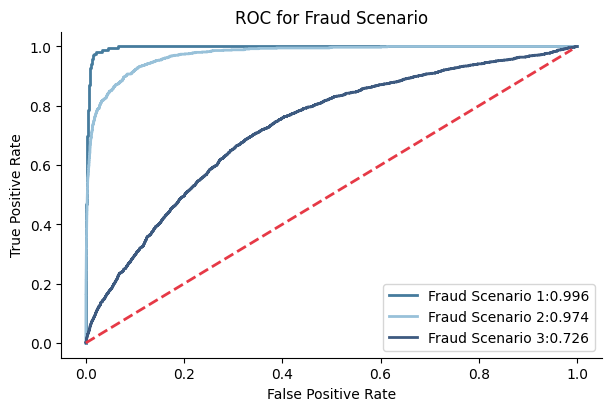

In [29]:
plot_roc_scenarios(data_scenarios_dict).show()

### Live Stream of Transactions Scoring with Model API

In [12]:
import datetime 
user = 27
user_trx_total = transactions_df.loc[transactions_df["CUSTOMER_ID"]==user,:].copy().reset_index(drop=True)

In [13]:
transaction_period = transactions_df.loc[(transactions_df["TX_DATETIME"].dt.date>datetime.date(2018,4,1)) & ( transactions_df["TX_DATETIME"].dt.date<datetime.date(2018,6,1)),:]
X_train = create_feature_matrix(transaction_period,windows_size_in_days = [1,5,7,15,30],delay_period=7)
target = "TX_FRAUD"


In [14]:
target = "TX_FRAUD"

index = "TX_DATETIME"

train_period = "2018-07-01"

customer_features = [i for i in X_train.columns if "CUSTOMER_ID_" in i]

flag_features = [i for i in X_train.columns if "TX_FLAG_" in i]

terminal_features = [i for i in X_train.columns if "TERMINAL_ID_" in i]

time_features = ['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_MONTH', 'TX_DAY', 'TX_HOUR', 'TX_MINUTE', 'TX_DURING_WEEKEND',
                 'TX_DURING_NIGHT']

helper_columns = ['TX_FRAUD', 'TX_FRAUD_SCENARIO', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID']

features = ['TX_AMOUNT'] + flag_features + terminal_features + customer_features + time_features

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class IsolationForestScore(BaseEstimator, TransformerMixin):
    
    def __init__(self,*args,**kwargs):
        self.model =  IsolationForest(*args,**kwargs)
        
    def fit(self,X,y=None,alert=5):
        X = check_array(X)
        self.model = self.model.fit(X)
        self.alert = np.percentile(self.model.score_samples(X),alert)
        return self
    
    def fit_transform(self,X,y=None):
        X = check_array(X)
        return self.model.fit(X).score_samples(X)
    
    def predict_proba(self,X,y=None):
        check_is_fitted(self.model)
        X = check_array(X)
        scores = self.model.score_samples(X)
        return scores
    
    def score_samples(self,X,y=None):
        check_is_fitted(self.model)
        X = check_array(X)
        scores = self.model.score_samples(X)
        return scores
    
    def predict(self,X,y=None):
        check_is_fitted(self.model)
        X = check_array(X)
        scores = self.model.score_samples(X)
        return (scores <  self.alert ).astype(int)*-1

In [16]:
model = IsolationForestScore()
# Fitting the model
model = model.fit(X_train[features])
model_name = "Isolation_Forest"

In [17]:
model.__getstate__()["model"].__getstate__()['_sklearn_version']

'1.1.1'

In [18]:
score_training = model.predict_proba(X_train[features])

Text(0.5, 1.0, 'Anomaly Score')

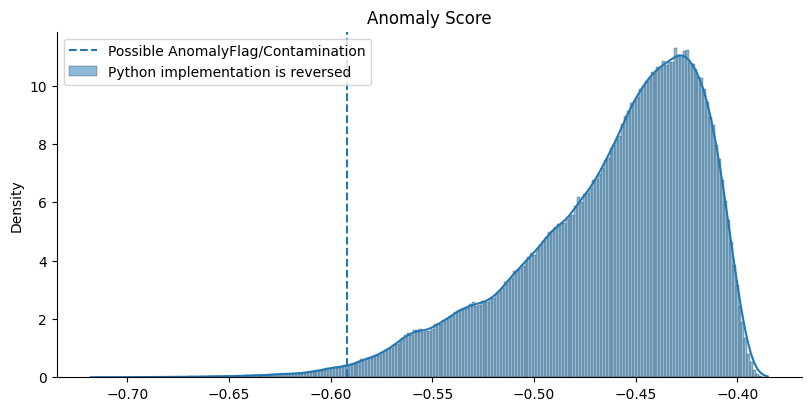

In [19]:
fig, ax = plt.subplots(layout='constrained',figsize=(8, 4))
sns.histplot(pd.Series(score_training), kde=True,stat="density",ax = ax,label = "Python implementation is reversed")
ax.spines[['right', 'top']].set_visible(False)
plt.axvline(np.percentile(score_training,1),linestyle = "--",label="Possible AnomalyFlag/Contamination")
plt.legend()
ax.set_title("Anomaly Score")

#### Model Deployment on Cloud

In [20]:
from src.scoring.credentials_api import *
from src.scoring.model_api import (APIClient,
                                   store_model, 
                                   deploy_model,features
                                   )

In [21]:
client = APIClient(wml_credentials)
client.set.default_space(space_id)

'SUCCESS'

In [22]:
#client.spaces.list()

In [23]:
#version = 1
#published_model = store_model(model,client,model_name = f"{model_name}_{version}",
#                              sofware_spec_uid=None)
#published_model

In [24]:
#deployment_name = f"Online_{model_name}_v{version}"
#deployment_uid = deploy_model(deployment_name,published_model,client)

#### Scoring Transaction

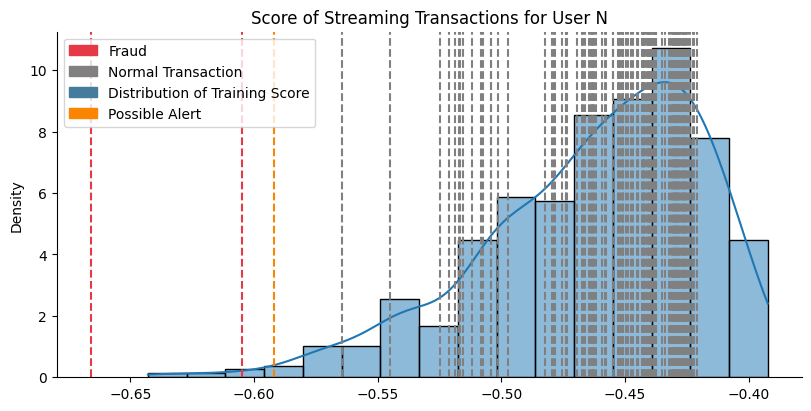

In [25]:
import time 
import matplotlib.patches as mpatches
fig, ax = plt.subplots(layout='constrained',figsize=(8, 4))
sns.histplot(pd.Series(score_training).sample(500), kde=True,stat="density",ax = ax,label = "Distribution of Anomaly Score in Past TRX")
plt.axvline(np.percentile(score_training,1),linestyle = "--",label="Possible AnomalyFlag/Contamination",color = "#fb8500")
user_trx =  user_trx_total.loc[ ( user_trx_total["TX_DATETIME"].dt.date >  datetime.date(2018,4,1) )  & ( user_trx_total["TX_DATETIME"].dt.date <  datetime.date(2018,6,1)  ) ]
last_trx_idx = user_trx.index[-1]
for i in range(100):
    #time.sleep(0.1)
    last_trx_idx+=1
    user_trx  = user_trx_total.iloc[0:last_trx_idx,:]
    X_test = create_feature_matrix(user_trx,windows_size_in_days = [1,5,7,15,30],delay_period=7).tail(1)
    
    #________________Online Scoring_____________________
    #fields = features
    #values = X_test[features].values
    #deployment_uid = 'b5ced764-f587-4fe7-8a50-a8b482bf2b99'
    #scoring_payload = {"input_data": [{"fields": fields, "values": values}]}
    #predictions = client.deployments.score(deployment_uid, scoring_payload)
    #score = predictions['predictions'][0]['values'][0][-1]
    #____________________________________________________
    
    score = model.score_samples(X_test[features])[0]
    #print(f"Score of Isolation forest: {scores[0]}")
    #display( user_trx.tail(1) )
    if user_trx["TX_FRAUD"].tail(1).item() == 1:
        ax.axvline(score,linestyle = "--", color="#e63946")
    else:
        ax.axvline(score,linestyle = "--", color="grey")
        

red_patch = mpatches.Patch(color='#e63946', label='Fraud')
blue_patch = mpatches.Patch(color='grey', label='Normal Transaction')
dist_patch = mpatches.Patch(color='#457b9d', label='Distribution of Training Score')
flag_patch = mpatches.Patch(color='#fb8500', label='Possible Alert')
ax.spines[['right', 'top']].set_visible(False)
ax.set_title("Score of Streaming Transactions for User N")
plt.legend(handles = [red_patch,blue_patch,dist_patch,flag_patch])
plt.show()

In [26]:
#fig.savefig('anomaly_score_api.png',transparent=True)

### Live Scoring

In [27]:
import time 

user_trx =  user_trx_total.loc[ ( user_trx_total["TX_DATETIME"].dt.date >  datetime.date(2018,4,1) )  
                               & ( user_trx_total["TX_DATETIME"].dt.date <  datetime.date(2018,6,1)  ) ]
last_trx_idx = user_trx.index[-1]
for i in range(5):
    time.sleep(1)
    last_trx_idx+=1
    user_trx  = user_trx_total.iloc[0:last_trx_idx,:]
    X_test = create_feature_matrix(user_trx,windows_size_in_days = [1,5,7,15,30],delay_period=7).tail(1)
    print("Transaction Created")
    display(user_trx.tail(1) )
    t0 = time.time()
    #________________Online Scoring_____________________
    values = X_test[features].values
    deployment_uid = 'e61354fe-168f-4185-ace6-f709709e5b81'
    scoring_payload = {"input_data": [{"fields": features, "values": values}]}
    predictions = client.deployments.score(deployment_uid, scoring_payload)
    score = predictions['predictions'][0]['values'][0][-1]
    #____________________________________________________
    t1 = time.time()
    print(f"Evaluation completed in: {round(t1-t0,3)} seconds")
    alert = -0.6
    display(f"Score of Isolation forest: {round(score,4)}")
    display(f"Possible Alert of Isolation forest: {alert}")
    display(f"Transaction is Fraud: {round(score,4) < alert}")
    
    #local_score = model.score_samples(X_test[features])[0]
    #display(f"Local Score of Isolation forest: {round(local_score,4)}")
    
    print("*"*150)

Transaction Created


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
218,581868,2018-05-31 14:03:39,27,1818,35.6,5234619,60,0,0


Evaluation completed in: 0.498 seconds


'Score of Isolation forest: -0.428'

'Possible Alert of Isolation forest: -0.6'

'Transaction is Fraud: False'

******************************************************************************************************************************************************
Transaction Created


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
219,588441,2018-06-01 09:50:00,27,4592,32.74,5305800,61,0,0


Evaluation completed in: 0.378 seconds


'Score of Isolation forest: -0.4315'

'Possible Alert of Isolation forest: -0.6'

'Transaction is Fraud: False'

******************************************************************************************************************************************************
Transaction Created


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
220,592529,2018-06-01 16:08:10,27,2882,56.21,5328490,61,0,0


Evaluation completed in: 0.372 seconds


'Score of Isolation forest: -0.4224'

'Possible Alert of Isolation forest: -0.6'

'Transaction is Fraud: False'

******************************************************************************************************************************************************
Transaction Created


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
221,593103,2018-06-01 17:14:43,27,5741,45.22,5332483,61,0,0


Evaluation completed in: 0.31 seconds


'Score of Isolation forest: -0.4159'

'Possible Alert of Isolation forest: -0.6'

'Transaction is Fraud: False'

******************************************************************************************************************************************************
Transaction Created


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
222,593765,2018-06-01 18:51:54,27,8391,48.75,5338314,61,0,0


Evaluation completed in: 0.3 seconds


'Score of Isolation forest: -0.4244'

'Possible Alert of Isolation forest: -0.6'

'Transaction is Fraud: False'

******************************************************************************************************************************************************
